In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.4:33593")
client

Client Scheduler: tcp://10.32.16.4:33593 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 11 Cores: 22 Memory: 126.50 GB


# \begin{equation*} \frac{D \sigma}{D t} = \dot\sigma_{\theta} = \frac{\partial \sigma_{\theta}}{\partial \theta} \dot\theta + \frac{\partial \sigma_{\theta}}{\partial S} \dot S \end{equation*}
## **ECCO**

In [29]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba
#from fastjmd95 import rho, drhods, drhodt

In [3]:
xr.set_options(display_style='text')

In [5]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_slt, ds_tmp, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    SALT                      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    SALT_snp                  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA                     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA_snp                 (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    dt                        (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_SLT          (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH      (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH           (time, j, i, k) float32 dask.array<chunksize=(1, 50, 95, 50), meta=np.ndarray>
    total_tendency_TH_truth   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    UVEL                      (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                      (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [6]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [7]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [8]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

# <font color='Green'> \begin{equation*} Temperature \end{equation*} </font>

## <font color='Green'> \begin{equation*} \alpha \approx - \frac{1}{\rho} \frac{\partial \rho}{\partial \theta} \end{equation*} </font>

## <span style='background:Yellow'> **Is `jmd95numba` already making drho/dtheta negative or do I multiply the neg?** </span>
Shanice: The github code doesn't seem to have negative...

Ryan:

### **Additional Questions:**
* divide by constant rho, or same rho as drhodt?
* turn theta into heat (divide by heat capacity)?

In [16]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, ds.SALT, ds.THETA, 2000,
                        output_dtypes=[ds.SALT.dtype],
                        dask='parallelized').reset_coords(drop=True).load()

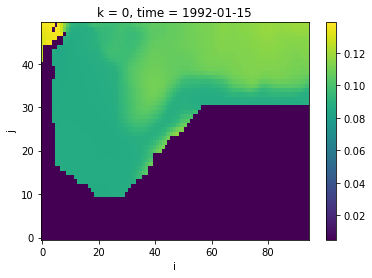

In [19]:
(-drhodt[0,0]).plot()

In [23]:
runit2mass = 1.035e3 #rho_0
heat_capacity_cp = 3.994e3 #J/˚K/kg

In [39]:
alpha = - drhodt / runit2mass

## <font color='Green'> \begin{equation*} \alpha \dot \theta \approx - \frac{1}{\rho} \frac{\partial \rho}{\partial \theta} \dot \theta \end{equation*} </font>

In [31]:
rhs_theta = (ds.conv_horiz_adv_flux_TH + 
              ds.conv_horiz_diff_flux_TH + 
              ds.conv_vert_adv_flux_TH +
              ds.conv_vert_diff_flux_TH + 
              ds.surface_flux_conv_TH + 
              ds.sw_flux_conv_TH).load()

lhs_theta = ds.total_tendency_TH_truth.load()

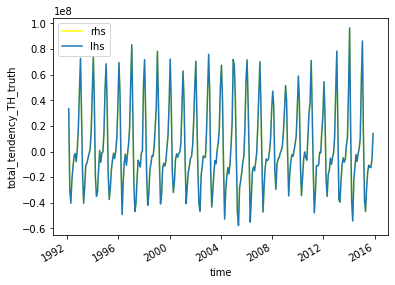

In [88]:
#checking equality
rhs_theta[1:-1].sum(['i', 'j', 'k']).plot(label='rhs', color='yellow')
lhs_theta[1:-1].sum(['i', 'j', 'k']).plot(label='lhs')
plt.legend();

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


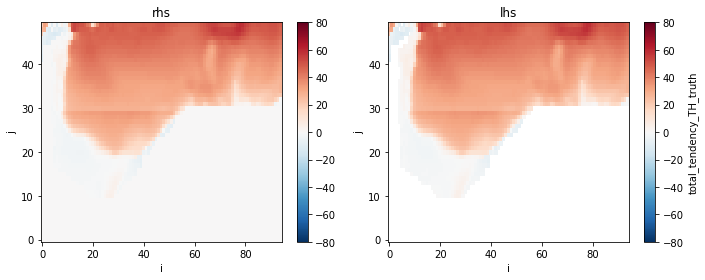

In [89]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
rhs_theta[1:-1].mean(dim=['time', 'k']).plot(ax=ax0, vmax=80)
ax0.set_title('rhs')
lhs_theta[1:-1].mean(dim=['time', 'k']).plot(ax=ax1, vmax=80)
ax1.set_title('lhs')
plt.tight_layout();

In [57]:
rhs_vars = [dvar for dvar in ds_tmp.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_tmp[dvar] for dvar in rhs_vars])
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float32, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

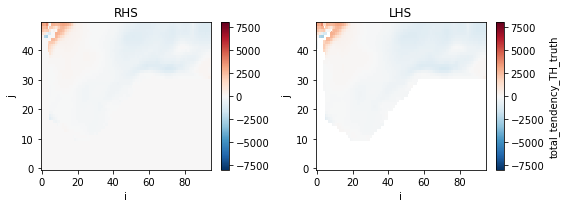

In [65]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[200, 0].plot(ax=ax0, robust=True, vmax=8e3)
ax0.set_title('RHS')

ds.total_tendency_TH_truth[200, 0].plot(ax=ax1, robust=True, vmax=8e3)
ax1.set_title('LHS')
plt.tight_layout();

### Density Flux (temp component

In [90]:
rhs_sig2_theta = (alpha * rhs_theta[1:-1]).load()
lhs_sig2_theta = (alpha * lhs_theta[1:-1]).load()

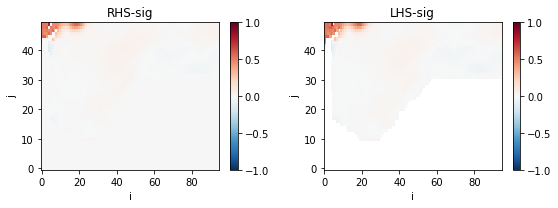

In [96]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
rhs_sig2_theta[200, 0].plot(ax=ax0, robust=True, vmax=1)
ax0.set_title('RHS-sig')

lhs_sig2_theta[200, 0].plot(ax=ax1, robust=True, vmax=1)
ax1.set_title('LHS-sig')
plt.tight_layout();

# <font color='Green'> \begin{equation*} Salinity \end{equation*} </font>

## <font color='Green'> \begin{equation*} \beta \approx \frac{1}{\rho} \frac{\partial \rho}{\partial S} \end{equation*} </font>

In [97]:
drhods = xr.apply_ufunc(jmd95numba.drhods, ds.SALT, ds.THETA, 2000,
                        output_dtypes=[ds.SALT.dtype],
                        dask='parallelized').reset_coords(drop=True).load()

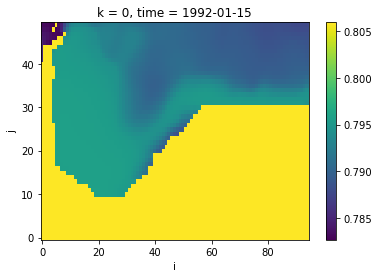

In [98]:
drhods[0,0].plot()

In [99]:
beta = drhods / runit2mass

## <font color='Green'> \begin{equation*} \beta \dot S \approx \frac{1}{\rho} \frac{\partial \rho}{\partial S} \dot S \end{equation*} </font>

In [103]:
rhs_slt = (ds.conv_horiz_adv_flux_SLT +
                 ds.conv_horiz_diff_flux_SLT +
                 ds.conv_vert_adv_flux_SLT +
                 ds.conv_vert_diff_flux_SLT + 
                 ds.surface_flux_SLT +
                 ds.salt_plume).load()

lhs_slt = ds.total_tendency_SLT_truth.load()

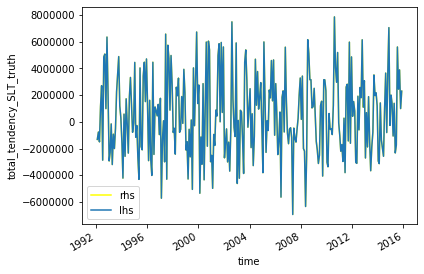

In [105]:
#checking equality
rhs_slt[1:-1].sum(['i', 'j', 'k']).plot(label='rhs', color='yellow')
lhs_slt[1:-1].sum(['i', 'j', 'k']).plot(label='lhs')
plt.legend();

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


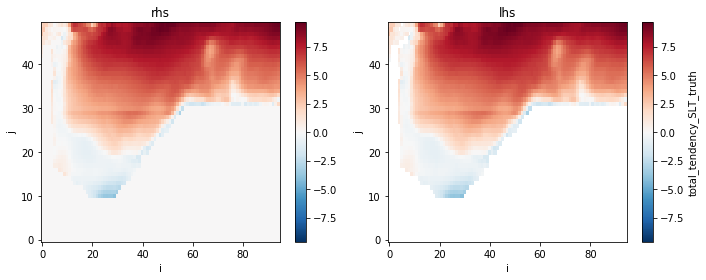

In [106]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
rhs_slt[1:-1].mean(dim=['time', 'k']).plot(ax=ax0)
ax0.set_title('rhs')
lhs_slt[1:-1].mean(dim=['time', 'k']).plot(ax=ax1)
ax1.set_title('lhs')
plt.tight_layout();

In [107]:
rhs_vars_slt = [dvar for dvar in ds_slt.data_vars
            if dvar != 'total_tendency_SLT_truth']
total_tendency_check_slt = sum([ds_slt[dvar] for dvar in rhs_vars_slt])
total_tendency_check_slt

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float32, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

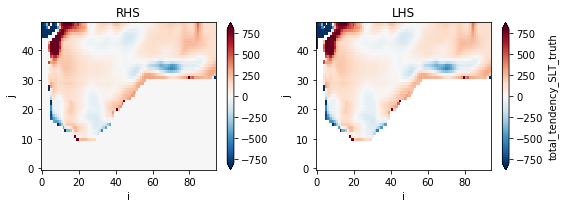

In [112]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check_slt[200, 0].plot(ax=ax0, robust=True, vmax=800)
ax0.set_title('RHS')

ds.total_tendency_SLT_truth[200, 0].plot(ax=ax1, robust=True, vmax=800)
ax1.set_title('LHS')
plt.tight_layout();

### Density Flux (salt component)

In [113]:
rhs_sig2_slt = (beta * rhs_slt[1:-1]).load()
lhs_sig2_slt = (beta * lhs_slt[1:-1]).load()

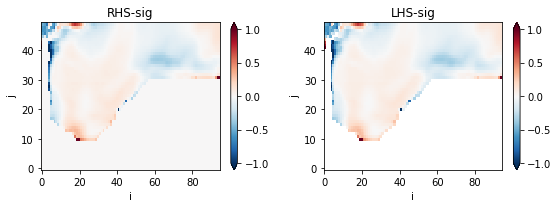

In [115]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
rhs_sig2_slt[200, 0].plot(ax=ax0, robust=True, vmax=1)
ax0.set_title('RHS-sig')

lhs_sig2_slt[200, 0].plot(ax=ax1, robust=True, vmax=1)
ax1.set_title('LHS-sig')
plt.tight_layout();